# Hyperparameter Optimization: ``num_simulations`

- Assumption: The more simulations i use the better my model will approximate unseen data. 
- BUT: The more simulations i use the more computation is needed to simulate data and train the model.
- Question: How many simulations are needed to have good performance and still acceptable computational load?

In [1]:
# add the 'src' as root folder, to find other modules in the project
import sys
sys.path.append("../../")

In [2]:
# external imports
import torch
import os

from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.utils import posterior_nn
from torch.distributions import Normal, Independent, Uniform

# local imports
from utilities.simulator.swing_equation import Swing
from utilities.analysis.distribution_analysis import DistributionAnalysis

ImportError: cannot import name 'TruncatedNormal' from 'torch.distributions' (/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/.venv/lib64/python3.9/site-packages/torch/distributions/__init__.py)

In [3]:
# define devices for simulation and training
sim_device = torch.device('cpu')
est_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# define output directory, for results
output_path = "../../results/hyperparameter_choices/num_rounds"

# define default sampling size
number_samples = 10**5

In [5]:
# Time and stepsize
T = 900
dt = 1

# Simulation process parameters
simulation_params = {
    "num_simulations": 10**5,
    "num_workers": os.cpu_count(),
    "simulation_batch_size": 50
}

# Density estimator parameters
training_params = {
    "model": 'maf',
    "hidden_features": 70,
    "num_transforms": 15,
    "num_bins": 25,
    "num_rounds": 5
}

# Add nonlinearity to the simulator
c1 = lambda x, y: -x*y-x*y**3
c2 = lambda x, y: -x*y-x*y**3

# Model for data simulation
simulator_model = Swing(f=c1, g=c2, dt=dt, T=T)

# True parameters for the swing equation
true_parameters = {
    'c_1': 0.01,
    'c_2': 0.0001,
    'P_0': 0.001,
    'P_1': 0.00001,
    '\epsilon': 0.001
}

# true parameters
true_parameters_base = torch.tensor(list(true_parameters.values()))
std_deviations_base = torch.tensor([0.001, 0.00001, 0.0001, 0.000001, 0.0001,])

mean_noise_scale = 1.0 
mean_noise_constant = 0 
std_noise_scale = 1.0 
std_noise_constant = 0 

# proposal: Uniform distributions around the true parameter value, negative values are not allowed
proposal = Independent(Uniform(low=0, high=true_parameters_base*10), 1)

# prior: Normal distributions around the true parameter value (with or without noise)
prior = Independent(Normal(loc=true_parameters_base*mean_noise_scale + mean_noise_constant, scale=std_deviations_base*std_noise_scale + std_noise_constant), 1)

# observation with true parameters
observation = simulator_model.simulator(true_parameters_base)

In [6]:
# check for compatibility
simulator, proposal = prepare_for_sbi(simulator_model.simulator, proposal)

# define neural posterior with given parameters for @SNPE
neural_posterior = posterior_nn(
    model=training_params.get('model'), 
    hidden_features=training_params.get('hidden_features'), 
    num_transforms=training_params.get('num_transforms'), 
    num_bins=training_params.get('num_bins')
)

# Set up the inference procedure with the SNPE procedure, and custom neural density estimator
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []

for _ in range(training_params.get('num_rounds')):
    simulations, parameters = simulate_for_sbi(
        simulator=simulator, 
        proposal=proposal, 
        num_simulations=simulation_params.get('num_simulations'), 
        num_workers=simulation_params.get('num_workers'), 
        simulation_batch_size=simulation_params.get('simulation_batch_size')
    )

    simulations.to(est_device)
    parameters.to(est_device)

    # Train the neural density estimator
    density_estimator = inference.append_simulations(simulations, parameters, data_device=est_device).train()

    # Build the posterior for the given parameters
    posterior = inference.build_posterior(density_estimator)

    posteriors.append(posterior)

    proposal = posterior.set_default_x(observation)

Running 100 simulations in 2 batches.:   0%|          | 0/2 [00:00<?, ?it/s]

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


Running 1000 simulations in 20 batches.:   0%|          | 0/20 [00:00<?, ?it/s]

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


Running 10000 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


Running 100000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

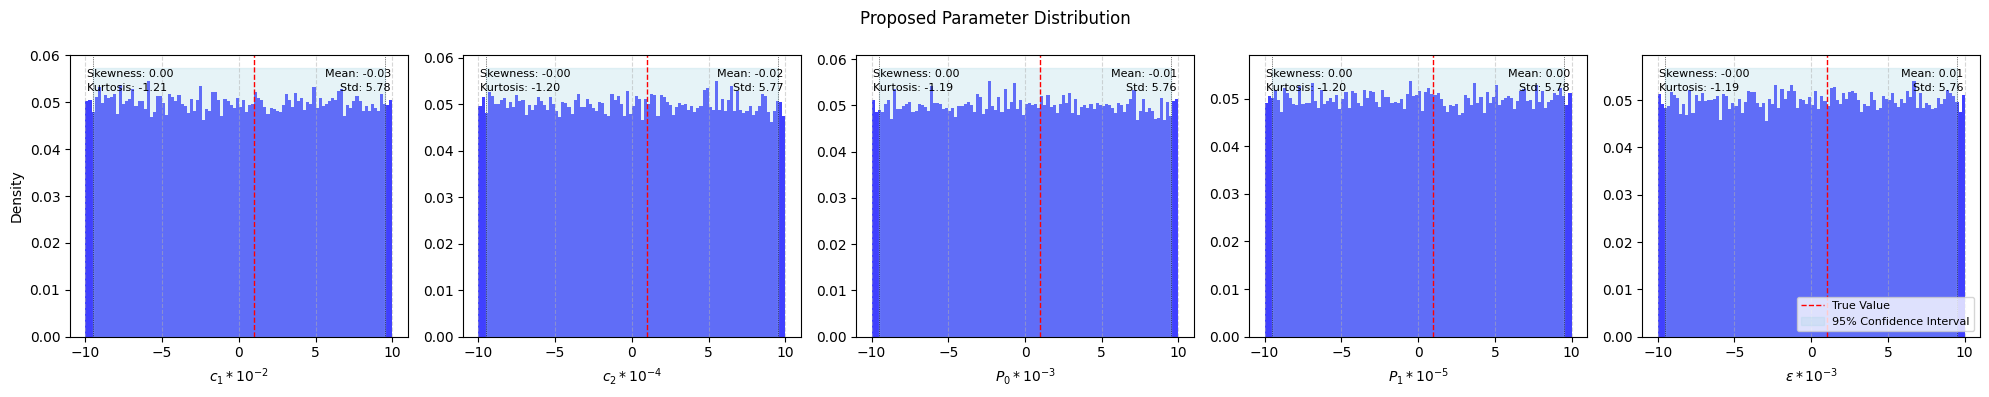

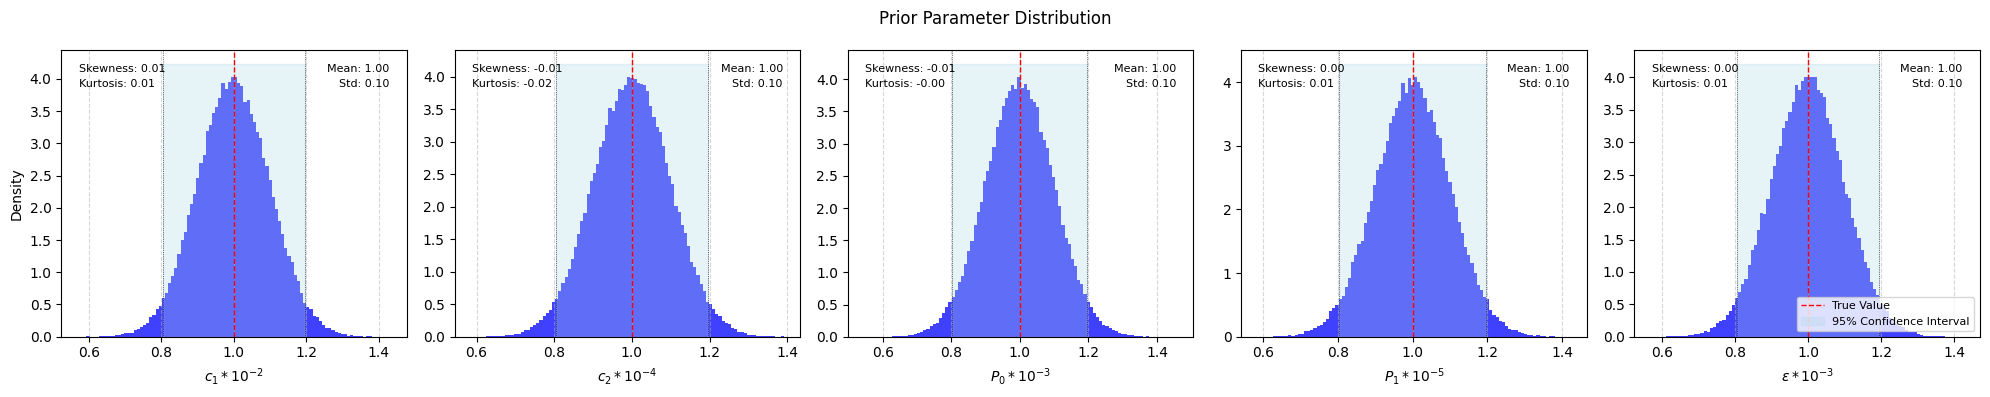

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

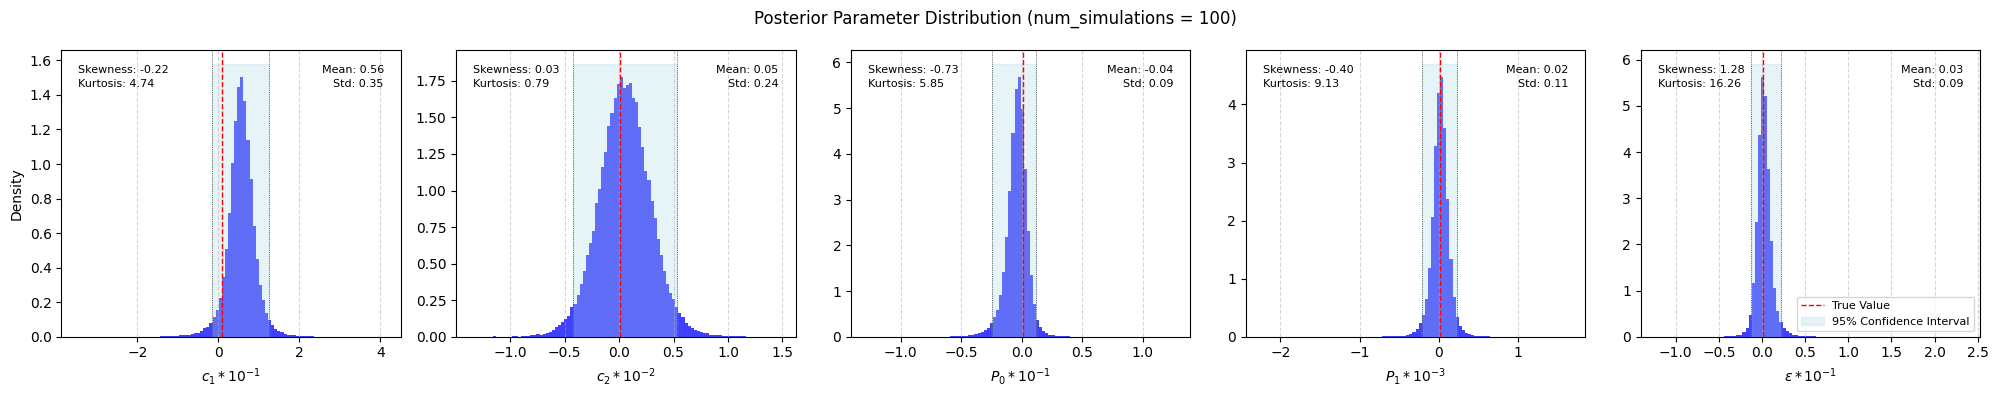

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

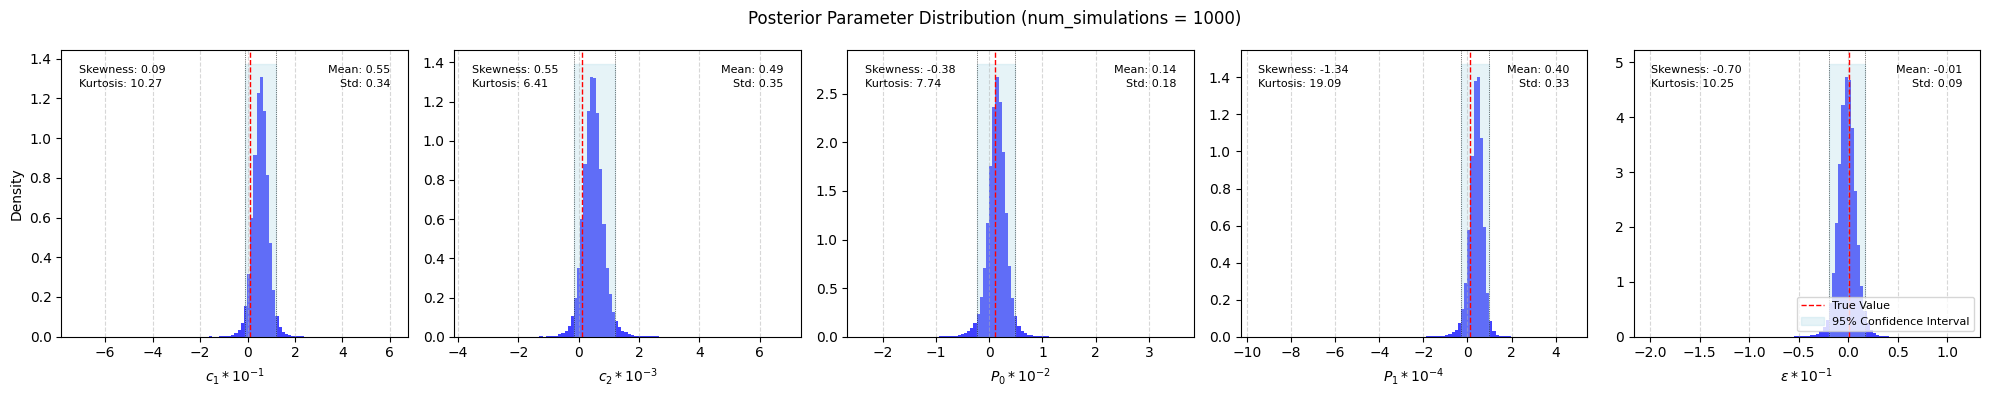

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

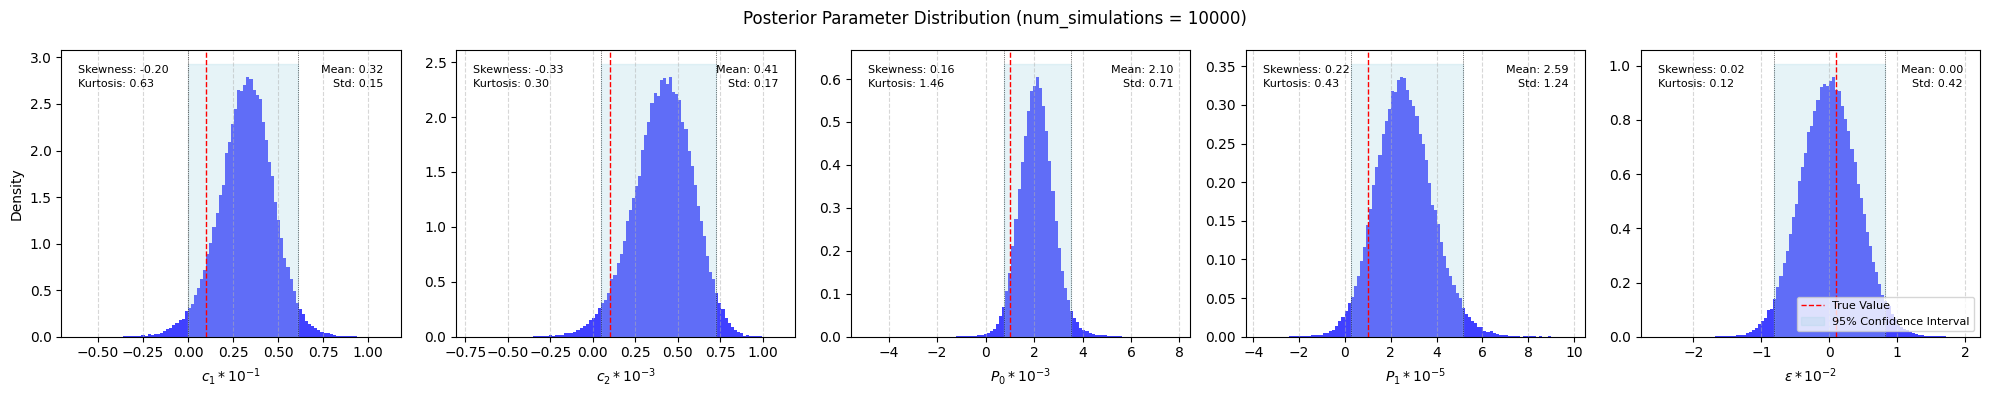

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

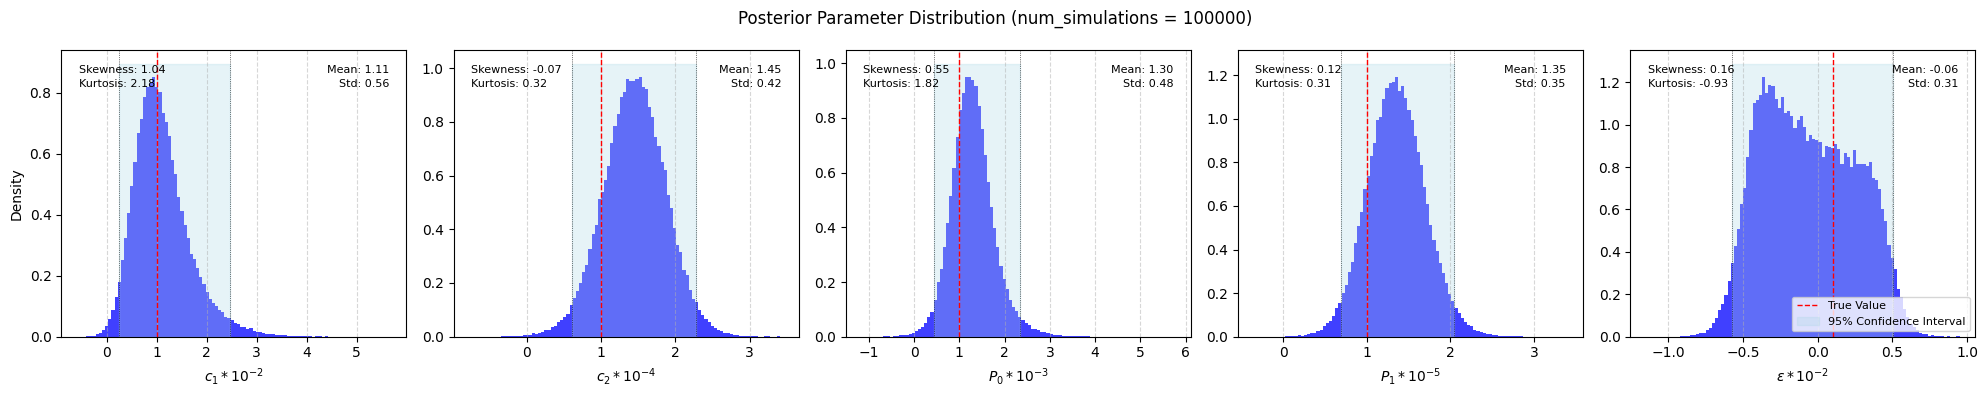

<Figure size 640x480 with 0 Axes>

In [8]:
distribution_analysis = DistributionAnalysis(true_parameters, output_path)

proposal_samples = proposal.sample((number_samples,))
prior_samples = prior.sample((number_samples,))

proposal_plot = distribution_analysis.plot_distribution_analytics(proposal_samples, 'Proposal', 'proposal')
prior_plot = distribution_analysis.plot_distribution_analytics(prior_samples, 'Prior', 'prior')

for (num_rounds, posterior) in enumerate(posteriors):
    posterior_samples = posterior.sample((number_samples,))
    posterior_plot = distribution_analysis.plot_distribution_analytics(posterior_samples, f'Posterior (num_rounds={num_rounds})', f'posterior_{num_rounds}')

In [ ]:
df_proposal = distribution_analysis.error_metrics(proposal_samples, 'proposal_statistics')
df_prior = distribution_analysis.error_metrics(prior_samples, 'prior_statistics')

for (num_rounds, posterior) in enumerate(posteriors):
    posterior_samples = posterior.sample((number_samples,))
    df_posterior = distribution_analysis.error_metrics(posterior_samples, f'posterior_statistics_{num_rounds}')